# Blackbird Dataset
## Description

Initial investigation into [MIT's Blackbird Dataset](http://blackbird-dataset.mit.edu/BlackbirdDatasetData/dice/yawForward/maxSpeed1p0/csv/?prefix=BlackbirdDatasetData/) which involves a quadcopter flying in a flight cage. This dataset has both a [paper](https://arxiv.org/abs/1810.01987) and [Github](https://github.com/mit-fast/Blackbird-Dataset) associated with it. The dataset is hosted by MIT with various CSV files available. There is a known issue with the column headers being miss aligned with the columns and some of the column units are fairely ambiguous.

## Data Exploration

Using the Pandas library, a singular flight data set will be downloaded into a pandas dataframe using a url. Due to the size of the datasets, csv files will be looked at individually. Ordering is:

1. State - Vicon system
        * Global position
        * Rotation angles (Quaternians)

2. IMU - Xsens MTi-3 IMU
        * Linear Acceleration in Body frame [m/s]
        * Rotations in Body frame [dps](?)

3. PWM
        * Individual Motor PWMS [1000 - 2000 nanosec]

4. Rotor RPM
        * Motors are samples 1-4 with stamps noted

5. Pose Ref
        * Reference Position and Orientation (?)

### State CSV

The state csv file contains the positional and rotational states as captured by the camera system. Reported information of interested is the 3D position of the quadcopter as well as the vehicle rotation stored in a quaternion. Update rate appears to be slightly slower than 50 Hz based on the reported rosbagTimestamp but the associated paper seems to indicated it can/was record up to 360 Hz which would indicate a discrepancy.

In [1]:
import pandas as pd
import io
import requests

urlhead = "http://blackbird-dataset.mit.edu/BlackbirdDatasetData/" + \
          "figure8/" + \
          "yawConstant/" +\
          "maxSpeed0p5/csv/"

url = urlhead + "blackbird_slash_state.csv"
#contents = requests.get(url).content
pos_and_orien = pd.read_csv(io.StringIO(requests.get(url).content.decode('utf-8')))
pos_and_orien.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77287 entries, 0 to 77286
Data columns (total 17 columns):
rosbagTimestamp    77287 non-null int64
header             0 non-null float64
seq                77287 non-null int64
stamp              0 non-null float64
secs               77287 non-null int64
nsecs              77287 non-null int64
frame_id           77287 non-null object
pose               0 non-null float64
position           0 non-null float64
x                  77287 non-null float64
y                  77287 non-null float64
z                  77287 non-null float64
orientation        0 non-null float64
x.1                77287 non-null float64
y.1                77287 non-null float64
z.1                77287 non-null float64
w                  77287 non-null float64
dtypes: float64(12), int64(4), object(1)
memory usage: 10.0+ MB


In [2]:
pos_and_orien.head()

,rosbagTimestamp,header,seq,stamp,secs,nsecs,frame_id,pose,position,x,y,z,orientation,x.1,y.1,z.1,w
0,1526617312016142000,NaN,1,NaN,1526617312,16142000,"""mocap""",NaN,NaN,-3.393845,0.261713,-0.926976,NaN,-0.008990,0.024020,-0.031950,0.999160
1,1526617312018921000,NaN,4,NaN,1526617312,18921000,"""mocap""",NaN,NaN,-3.393903,0.261800,-0.926810,NaN,-0.008838,0.024517,-0.031534,0.999163
2,1526617312021699000,NaN,6,NaN,1526617312,21699000,"""mocap""",NaN,NaN,-3.393929,0.261766,-0.927067,NaN,-0.009055,0.023970,-0.031980,0.999160
3,1526617312024477000,NaN,8,NaN,1526617312,24477000,"""mocap""",NaN,NaN,-3.393887,0.261701,-0.926861,NaN,-0.008776,0.023786,-0.031966,0.999167
4,1526617312027254000,NaN,11,NaN,1526617312,27254000,"""mocap""",NaN,NaN,-3.393841,0.261676,-0.926848,NaN,-0.008549,0.024100,-0.031734,0.999169


In [3]:
#Adjustments
#Adjust timescale
sec_start_ref = pos_and_orien.at[1,'secs']
nsec_start_ref = pos_and_orien.at[1,'nsecs']

#pos_and_orien['secs'] = pos_and_orien['secs'] - sec_start_ref
#pos_and_orien['nsecs'] = pos_and_orien['nsecs'] - nsec_start_ref

# Drop empty columns
pos_and_orien = pos_and_orien.drop(['header',\
                                    'stamp',\
                                    'pose',\
                                    'position',\
                                    'orientation'],\
                                    axis=1)
#Rename variables and add units
pos_and_orien = pos_and_orien.rename(columns={"x" : "px_[m]",\
                                              "y" : "py_[m]",\
                                              "z" : "pz_[m]",\
                                              "x.1" : "qx",\
                                              "y.1" : "qy",\
                                              "z.1" : "qz",\
                                              "w" : "qw"})

pos_and_orien.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77287 entries, 0 to 77286
Data columns (total 12 columns):
rosbagTimestamp    77287 non-null int64
seq                77287 non-null int64
secs               77287 non-null int64
nsecs              77287 non-null int64
frame_id           77287 non-null object
px_[m]             77287 non-null float64
py_[m]             77287 non-null float64
pz_[m]             77287 non-null float64
qx                 77287 non-null float64
qy                 77287 non-null float64
qz                 77287 non-null float64
qw                 77287 non-null float64
dtypes: float64(7), int64(4), object(1)
memory usage: 7.1+ MB


In [4]:
import numpy as np
import math

def quaternion_to_euler(qw, qx, qy, qz):
    """From a quaternion to aircraft euler angles.
    
    Keyword arguments:
    qw -- rotational component
    qx -- x-axis component
    qy -- y-axis component
    qz -- z-axis component
    """
    q = np.array([qw, qx, qy, qz], dtype=np.float64, copy=True)
    ssq = np.dot(q,q) #Sum of squares norm
    Rmatrix = None #Rotation matrix
    
    #Machine Precission work
    if ssq < 10 ** -6:
        Rmatrix = np.identity(3)
    else:
        q *= math.sqrt(2/ssq)
        q = np.outer(q,q)
        
        """
        From:
            Representing Attitude: Euler Angles, Unit Quaternions, and Rotation Vectors
                by James Diebel, Stanford University (2006)
        Eq 125:
        | q0^2 + q1^2 - q2^2 - q3^2 | 2(q1*q2 + q3*q4)          | 2(q1*q3 - q0*q2)          |
        | 2(q1*q2 - q3*q4)          | q0^2 - q1^2 + q2^2 - q3^2 | 2(q2*q3 + q0*q1)          |
        | 2(q1*q3 + q0*q2)          | 2(q2*q3 - q0*q1)          | q0^2 - q1^2 - q2^2 + q3^2 |
        """
        
        Rmatrix = np.array((
            (1.0 - q[2,2] - q[3,3],       q[1,2] + q[0,3],       q[1,3] - q[0,2]),
            (      q[1,2] - q[0,3], 1.0 - q[1,1] - q[3,3],       q[2,3] + q[0,1]),
            (      q[1,3] + q[0,2],       q[2,3] - q[0,1], 1.0 - q[1,1] - q[2,2])
        ), dtype=np.float64)

    #Determine the Euler angles
    theta = np.arcsin(-Rmatrix[0,2]) #Assuming theta in [-pi/2, pi/2]
    phi = np.arctan(Rmatrix[1,2]/Rmatrix[2,2]) #Assuming phi in [-pi/2, pi/2]

    Rphi = np.array((
        (1,             0,             0),
        (0,  math.cos(phi), math.sin(phi)),
        (0, -math.sin(phi), math.cos(phi))
    ), dtype=np.float64)
    Rtheta = np.array((
        (math.cos(theta), 0, -math.sin(theta)),
        (              0, 1,                0),
        (math.sin(theta), 0,  math.cos(theta))
    ), dtype=np.float64)
    
    #Determine rotation matrix by psi
    Rpsi = np.matmul(np.transpose(np.matmul(Rphi,
                                            Rtheta)),
                    Rmatrix)
    
    psi = np.arctan2(Rpsi[0,1], Rpsi[0,0])
    
    #return (Rmatrix, phi, theta, psi) #Testing
    return np.array((phi, theta, psi), dtype=np.float64)

qtestrot = np.pi/3
qtestvec = [1,0,0]
print(quaternion_to_euler(np.cos(qtestrot/2),
                          np.sin(qtestrot/2)*qtestvec[0],
                          np.sin(qtestrot/2)*qtestvec[1],
                          np.sin(qtestrot/2)*qtestvec[2]))

[ 1.04719755 -0.          0.        ]


In [5]:
# Transform quaternions into Euler angles
for i in range(pos_and_orien.index[-1]):
    q0 = pos_and_orien.at[i, 'qw']
    q1 = pos_and_orien.at[i, 'qx']
    q2 = pos_and_orien.at[i, 'qy']
    q3 = pos_and_orien.at[i, 'qz']
    euler_angles = quaternion_to_euler(q0, q1, q2, q3)
    pos_and_orien.at[i,'roll_[rad]']  = euler_angles[0]
    pos_and_orien.at[i,'pitch_[rad]'] = euler_angles[1]
    pos_and_orien.at[i,'yaw_[rad]']   = euler_angles[2]

<IPython.core.display.Javascript object>


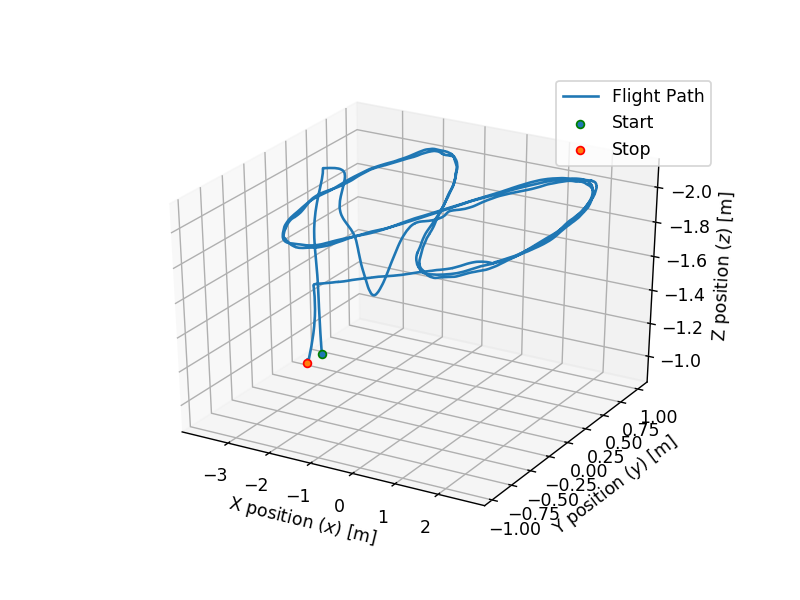

In [6]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.invert_zaxis()

Npao = pos_and_orien.index[-1]

ax.plot(pos_and_orien['px_[m]'],\
        pos_and_orien['py_[m]'],\
        pos_and_orien['pz_[m]'],\
        label="Flight Path")
ax.scatter(pos_and_orien.at[1,'px_[m]'],\
           pos_and_orien.at[1,'py_[m]'],\
           pos_and_orien.at[1,'pz_[m]'],\
           marker="o", edgecolor = "g", label="Start")
ax.scatter(pos_and_orien.at[Npao,'px_[m]'],\
           pos_and_orien.at[Npao,'py_[m]'],\
           pos_and_orien.at[Npao,'pz_[m]'],\
           marker="o", edgecolor = "r", label="Stop")
ax.set_xlabel("X position ($x$) [m]")
ax.set_ylabel("Y position ($y$) [m]")
ax.set_zlabel("Z position ($z$) [m]")
ax.legend()
plt.show()

<IPython.core.display.Javascript object>


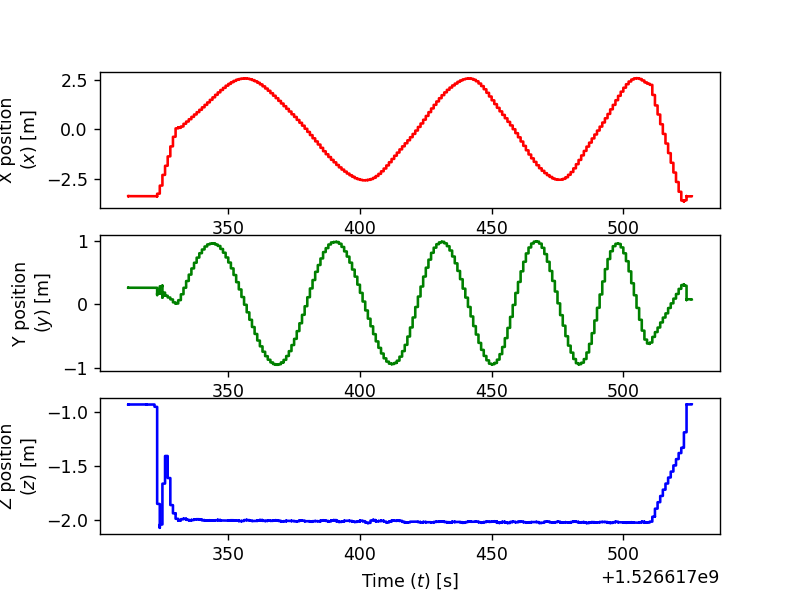

In [7]:
fig,ax = plt.subplots(3,1)

ax[0].plot(pos_and_orien['secs'], pos_and_orien['px_[m]'], color='r')
ax[1].plot(pos_and_orien['secs'], pos_and_orien['py_[m]'], color='g')
ax[2].plot(pos_and_orien['secs'], pos_and_orien['pz_[m]'], color='b')

ax[0].set_ylabel("X position\n($x$) [m]")
ax[1].set_ylabel("Y position\n($y$) [m]")
ax[2].set_ylabel("Z position\n($z$) [m]")
ax[2].set_xlabel("Time ($t$) [s]")

plt.show()

<IPython.core.display.Javascript object>


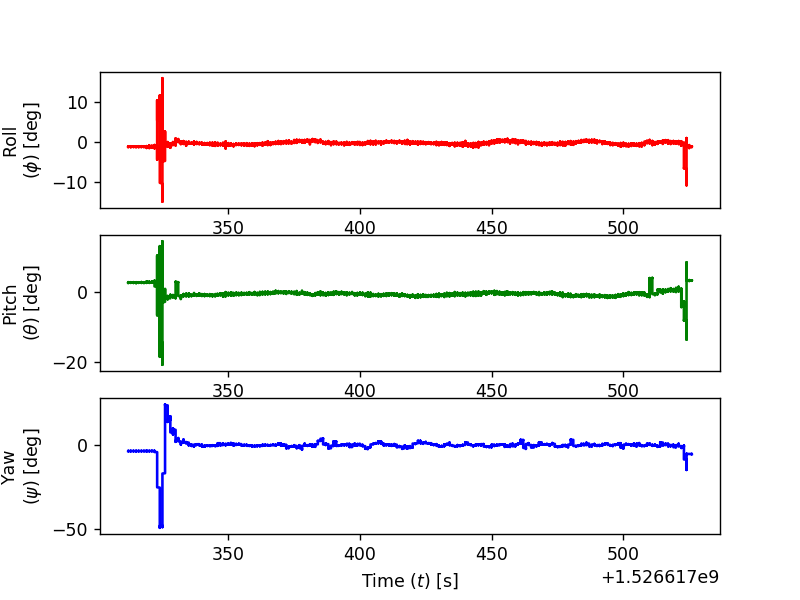

In [8]:
import math

fig,ax = plt.subplots(3,1)

ax[0].plot(pos_and_orien['secs'], pos_and_orien['roll_[rad]'].apply(math.degrees), color='r')
ax[1].plot(pos_and_orien['secs'], pos_and_orien['pitch_[rad]'].apply(math.degrees), color='g')
ax[2].plot(pos_and_orien['secs'], pos_and_orien['yaw_[rad]'].apply(math.degrees), color='b')

ax[0].set_ylabel("Roll\n($\phi$) [deg]")
ax[1].set_ylabel("Pitch\n($\\theta$) [deg]")
ax[2].set_ylabel("Yaw\n($\psi$) [deg]")
ax[2].set_xlabel("Time ($t$) [s]")

plt.show()

<IPython.core.display.Javascript object>


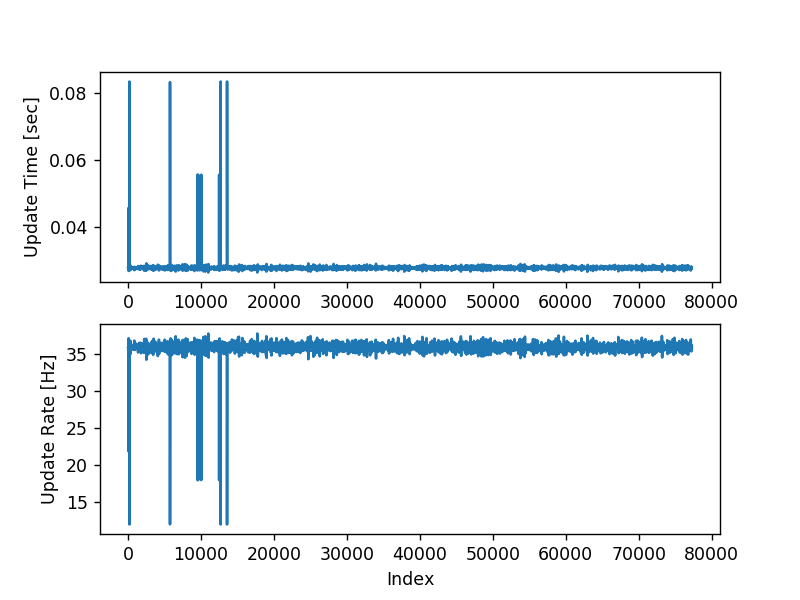

In [9]:
# Examine the reported update rates
update_time = pos_and_orien['rosbagTimestamp'].diff()
update_time = update_time * (10 ** -8) #Shift to seconds

update_rate = 1./update_time # Hz is 1/sec

fig,ax = plt.subplots(2,1)

ax[0].plot(update_time)
ax[1].plot(update_rate)

ax[0].set_ylabel("Update Time [sec]")
ax[1].set_ylabel("Update Rate [Hz]")
ax[1].set_xlabel("Index")
plt.show()

### IMU

The IMU theoretically is 100 Hz update which appears to be roughly correct when looking at the time stamps. The information of interest from the IMU is the acceleration and gyroscope in the quadcopter body frame. It has not been decerned whether or not the reported noise characteristics are correct.

In [10]:
url = urlhead + "blackbird_slash_imu.csv"
imu_df = pd.read_csv(io.StringIO(requests.get(url).content.decode('utf-8')))
imu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21298 entries, 0 to 21297
Data columns (total 23 columns):
rosbagTimestamp                   21298 non-null int64
header                            0 non-null float64
seq                               21298 non-null int64
stamp                             0 non-null float64
secs                              21298 non-null int64
nsecs                             21298 non-null int64
frame_id                          21298 non-null object
orientation                       0 non-null float64
x                                 21298 non-null float64
y                                 21298 non-null float64
z                                 21298 non-null float64
w                                 21298 non-null float64
orientation_covariance            21298 non-null object
angular_velocity                  0 non-null float64
x.1                               21298 non-null float64
y.1                               21298 non-null float64
z.1  

In [11]:
#Adjustments
#Adjust timescale
#imu_df['secs'] = imu_df['secs'] - sec_start_ref
#imu_df['nsecs'] = imu_df['nsecs'] - nsec_start_ref

# Drop empty columns
imu_df = imu_df.drop(['header',\
                      'stamp',\
                      'orientation',\
                      'angular_velocity',\
                      'linear_acceleration'],\
                     axis=1)
#Rename variables and add units
imu_df = imu_df.rename(columns={"x" : "qx",\
                                "y" : "qy",\
                                "z" : "qz",\
                                "w" : "qw",\
                                "x.1" : "omegax_[dps]",\
                                "y.1" : "omegay_[dps]",\
                                "z.1" : "omegaz_[dps]",\
                                "x.2" : "ax_[m/s2]",\
                                "y.2" : "ay_[m/s2]",\
                                "z.2" : "az_[m/s2]"})

imu_df.head()

,rosbagTimestamp,seq,secs,nsecs,frame_id,qx,qy,qz,qw,orientation_covariance,omegax_[dps],omegay_[dps],omegaz_[dps],angular_velocity_covariance,ax_[m/s2],ay_[m/s2],az_[m/s2],linear_acceleration_covariance
0,1526617313775493000,1,1526617313,775493000,"""imu""",0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-0.008281,0.000012,-0.004600,"[0.0001, 0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0,...",0.053711,-0.392242,-9.741584,"[0.01, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.01]"
1,1526617313785488000,2,1526617313,785488000,"""imu""",0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-0.007907,0.001821,-0.004601,"[0.0001, 0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0,...",0.053214,-0.393957,-9.768647,"[0.01, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.01]"
2,1526617313795714000,3,1526617313,795714000,"""imu""",0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-0.007325,0.001418,-0.004686,"[0.0001, 0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0,...",0.056948,-0.403248,-9.744291,"[0.01, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.01]"
3,1526617313805476000,4,1526617313,805476000,"""imu""",0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-0.006052,-0.000305,-0.003774,"[0.0001, 0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0,...",0.074306,-0.393690,-9.778463,"[0.01, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.01]"
4,1526617313815443000,5,1526617313,815443000,"""imu""",0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-0.007407,0.001025,-0.005490,"[0.0001, 0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0,...",0.067153,-0.394343,-9.781151,"[0.01, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.01]"


<IPython.core.display.Javascript object>


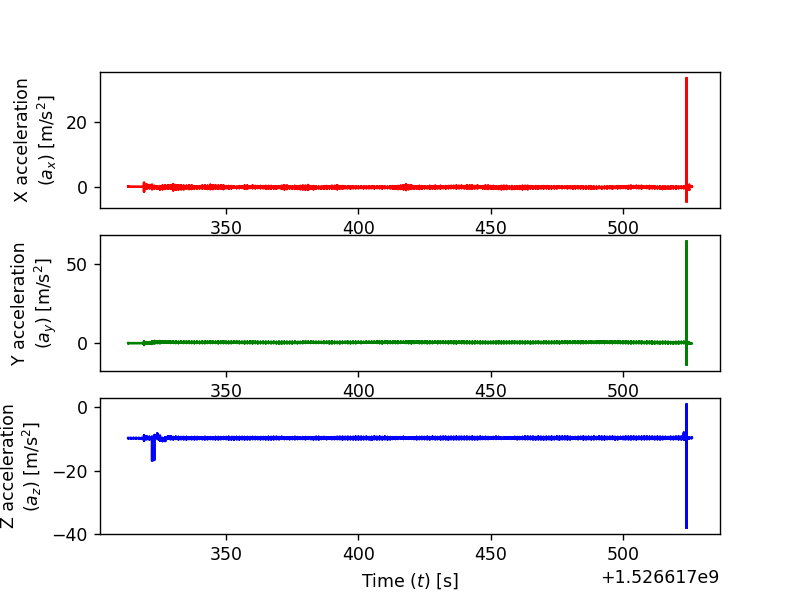

In [12]:
fig,ax = plt.subplots(3,1)

ax[0].plot(imu_df['secs'], imu_df['ax_[m/s2]'], color='r')
ax[1].plot(imu_df['secs'], imu_df['ay_[m/s2]'], color='g')
ax[2].plot(imu_df['secs'], imu_df['az_[m/s2]'], color='b')

ax[0].set_ylabel("X acceleration\n($a_x$) [m/s$^2$]")
ax[1].set_ylabel("Y acceleration\n($a_y$) [m/s$^2$]")
ax[2].set_ylabel("Z acceleration\n($a_z$) [m/s$^2$]")
ax[2].set_xlabel("Time ($t$) [s]")

plt.show()

<IPython.core.display.Javascript object>


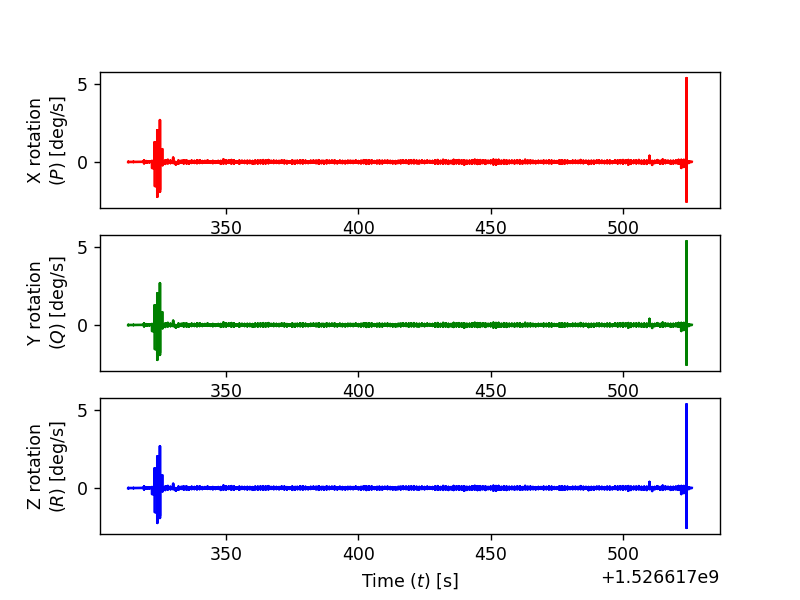

In [13]:
fig,ax = plt.subplots(3,1)

ax[0].plot(imu_df['secs'], imu_df['omegax_[dps]'], color='r')
ax[1].plot(imu_df['secs'], imu_df['omegax_[dps]'], color='g')
ax[2].plot(imu_df['secs'], imu_df['omegax_[dps]'], color='b')

ax[0].set_ylabel("X rotation\n($P$) [deg/s]")
ax[1].set_ylabel("Y rotation\n($Q$) [deg/s]")
ax[2].set_ylabel("Z rotation\n($R$) [deg/s]")
ax[2].set_xlabel("Time ($t$) [s]")

plt.show()

<IPython.core.display.Javascript object>


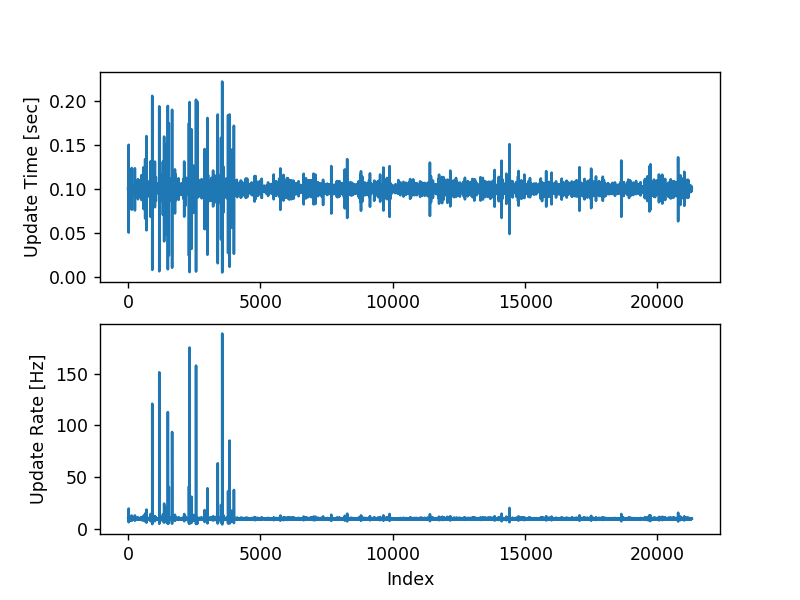

In [14]:
# Examine the reported update rates
update_time = imu_df['rosbagTimestamp'].diff()
update_time = update_time * (10 ** -8) #Shift to seconds

update_rate = 1./update_time # Hz is 1/sec

fig,ax = plt.subplots(2,1)

ax[0].plot(update_time)
ax[1].plot(update_rate)

ax[0].set_ylabel("Update Time [sec]")
ax[1].set_ylabel("Update Rate [Hz]")
ax[1].set_xlabel("Index")
plt.show()

### PWM CSV

The reported values of interest are the individual motor pwm commands sent from the controller to the quadcopter to achieve the desired manuever

In [15]:
url = urlhead + "blackbird_slash_pwm.csv"
pwm_df = pd.read_csv(io.StringIO(requests.get(url).content.decode('utf-8')))
pwm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39824 entries, 0 to 39823
Data columns (total 8 columns):
rosbagTimestamp    39824 non-null int64
header             0 non-null float64
seq                39824 non-null int64
stamp              0 non-null float64
secs               39824 non-null int64
nsecs              39824 non-null int64
frame_id           39824 non-null object
pwm                39824 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 2.4+ MB


In [16]:
# Drop empty columns
pwm_df = pwm_df.drop(['header',\
                      'stamp'],\
                     axis=1)

In [17]:
#Rename variables and add units
for i in range(pwm_df.index[-1]):
    pwms = pwm_df.at[i,'pwm'][1:-1].split(", ")
    pwm_df.at[i,'PWM1'] = int(pwms[0])
    pwm_df.at[i,'PWM2'] = int(pwms[1])
    pwm_df.at[i,'PWM3'] = int(pwms[2])
    pwm_df.at[i,'PWM4'] = int(pwms[3])

pwm_df.head()

,rosbagTimestamp,seq,secs,nsecs,frame_id,pwm,PWM1,PWM2,PWM3,PWM4
0,1526617313551168000,1,1526617313,551168000,"""0""","[1000, 1000, 1000, 1000]",1000.0,1000.0,1000.0,1000.0
1,1526617313556662000,2,1526617313,556662000,"""0""","[1000, 1000, 1000, 1000]",1000.0,1000.0,1000.0,1000.0
2,1526617313562032000,3,1526617313,562032000,"""0""","[1000, 1000, 1000, 1000]",1000.0,1000.0,1000.0,1000.0
3,1526617313567452000,4,1526617313,567452000,"""0""","[1000, 1000, 1000, 1000]",1000.0,1000.0,1000.0,1000.0
4,1526617313572855000,5,1526617313,572855000,"""0""","[1000, 1000, 1000, 1000]",1000.0,1000.0,1000.0,1000.0


<IPython.core.display.Javascript object>


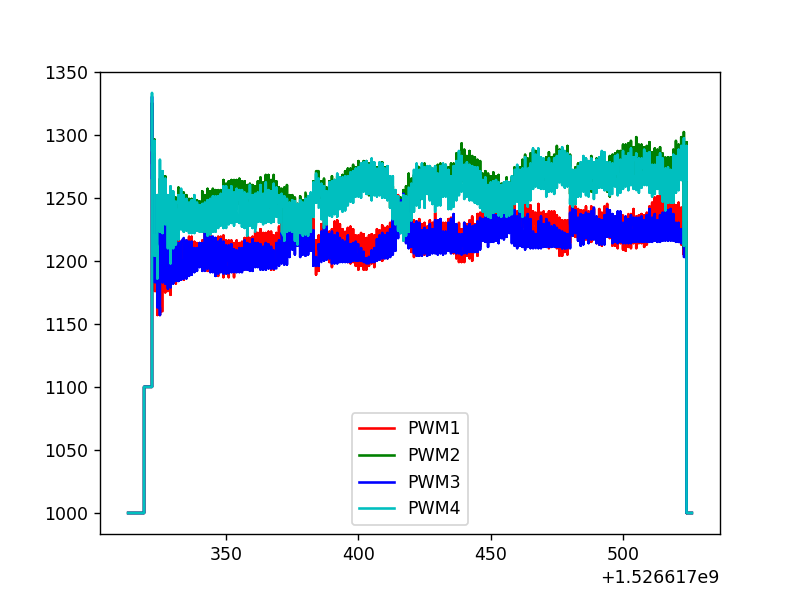

In [18]:
fig = plt.figure()
ax = plt.subplot(1,1,1)

ax.plot(pwm_df['secs'], pwm_df['PWM1'], label="PWM1", color="r")
ax.plot(pwm_df['secs'], pwm_df['PWM2'], label="PWM2", color="g")
ax.plot(pwm_df['secs'], pwm_df['PWM3'], label="PWM3", color="b")
ax.plot(pwm_df['secs'], pwm_df['PWM4'], label="PWM4", color="c")

ax.legend()
plt.show()

<IPython.core.display.Javascript object>


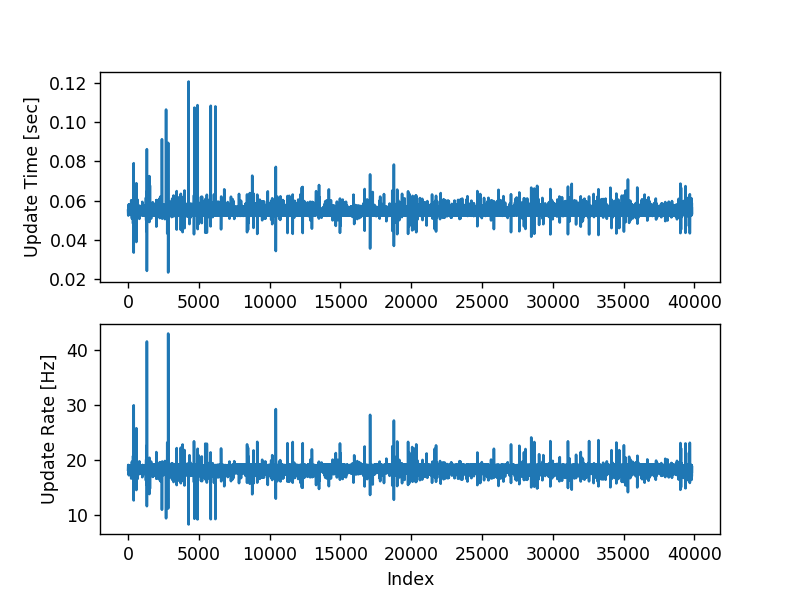

In [19]:
# Examine the reported update rates
update_time = pwm_df['rosbagTimestamp'].diff()
update_time = update_time * (10 ** -8) #Shift to seconds

update_rate = 1./update_time # Hz is 1/sec

fig,ax = plt.subplots(2,1)

ax[0].plot(update_time)
ax[1].plot(update_rate)

ax[0].set_ylabel("Update Time [sec]")
ax[1].set_ylabel("Update Rate [Hz]")
ax[1].set_xlabel("Index")
plt.show()

### Motor RPM CSV

These are motor rotational speeds recordings list in rpm which was conglomerated from the motor encoders. The overall timestamp seems to be working just right although the individual motor encodings timestamps have something weird happening. The time doesn't seem to be updated correctly and occasionally you will get negative rates.


In [20]:
url = urlhead + "blackbird_slash_rotor_rpm.csv"
motors_df = pd.read_csv(io.StringIO(requests.get(url).content.decode('utf-8')))
motors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39825 entries, 0 to 39824
Data columns (total 21 columns):
rosbagTimestamp    39825 non-null int64
header             0 non-null float64
seq                39825 non-null int64
stamp              0 non-null float64
secs               39825 non-null int64
nsecs              39825 non-null int64
frame_id           39825 non-null object
sample_stamp       0 non-null float64
-                  39825 non-null int64
secs.1             39825 non-null int64
nsecs.1            39825 non-null int64
-.1                39825 non-null int64
secs.2             39825 non-null int64
nsecs.2            39825 non-null int64
-.2                39825 non-null int64
secs.3             39825 non-null int64
nsecs.3            39825 non-null object
-.3                0 non-null float64
secs.4             0 non-null float64
nsecs.4            0 non-null float64
rpm                0 non-null float64
dtypes: float64(7), int64(12), object(2)
memory usage: 6.4+ MB


In [21]:
motors_df.head()

,rosbagTimestamp,header,seq,stamp,secs,nsecs,frame_id,sample_stamp,-,secs.1,...,-.1,secs.2,nsecs.2,-.2,secs.3,nsecs.3,-.3,secs.4,nsecs.4,rpm
0,1526617313551167000,NaN,1,NaN,1526617313,551167000,"""0""",NaN,1526617274,767570000,...,167629000,1526617274,767570000,1526617285,167629000,"[0.0, 0.0, 0.0, 0.0]",NaN,NaN,NaN,NaN
1,1526617313556660000,NaN,2,NaN,1526617313,556660000,"""0""",NaN,1526617274,767569000,...,167628000,1526617274,767569000,1526617285,167628000,"[0.0, 0.0, 0.0, 0.0]",NaN,NaN,NaN,NaN
2,1526617313562031000,NaN,3,NaN,1526617313,562031000,"""0""",NaN,1526617274,767569000,...,167628000,1526617274,767569000,1526617285,167628000,"[0.0, 0.0, 0.0, 0.0]",NaN,NaN,NaN,NaN
3,1526617313567451000,NaN,4,NaN,1526617313,567451000,"""0""",NaN,1526617274,767568000,...,167627000,1526617274,767568000,1526617285,167627000,"[0.0, 0.0, 0.0, 0.0]",NaN,NaN,NaN,NaN
4,1526617313572854000,NaN,5,NaN,1526617313,572854000,"""0""",NaN,1526617274,767567000,...,167626000,1526617274,767567000,1526617285,167626000,"[0.0, 0.0, 0.0, 0.0]",NaN,NaN,NaN,NaN


In [22]:
# Drop empty columns
motors_df = motors_df.drop(['header',\
                            'stamp',\
                            'sample_stamp',\
                            '-.3',\
                            'secs.4',\
                            'nsecs.4',\
                            'rpm'],\
                           axis=1)
#Rename variables and add units
motors_df = motors_df.rename(columns={"-"       : "secs_m1",\
                                      "secs.1"  : "nsecs_m1",\
                                      "nsecs.1" : "secs_m2",\
                                      "-.1"     : "nsecs_m2",\
                                      "secs.2"  : "secs_m3",\
                                      "nsecs.2" : "nsecs_m3",\
                                      "-.2"     : "secs_m4",\
                                      "secs.3"  : "nsecs_m4",\
                                      "nsecs.3" : "motor_vec"})

motors_df.head()

,rosbagTimestamp,seq,secs,nsecs,frame_id,secs_m1,nsecs_m1,secs_m2,nsecs_m2,secs_m3,nsecs_m3,secs_m4,nsecs_m4,motor_vec
0,1526617313551167000,1,1526617313,551167000,"""0""",1526617274,767570000,1526617285,167629000,1526617274,767570000,1526617285,167629000,"[0.0, 0.0, 0.0, 0.0]"
1,1526617313556660000,2,1526617313,556660000,"""0""",1526617274,767569000,1526617285,167628000,1526617274,767569000,1526617285,167628000,"[0.0, 0.0, 0.0, 0.0]"
2,1526617313562031000,3,1526617313,562031000,"""0""",1526617274,767569000,1526617285,167628000,1526617274,767569000,1526617285,167628000,"[0.0, 0.0, 0.0, 0.0]"
3,1526617313567451000,4,1526617313,567451000,"""0""",1526617274,767568000,1526617285,167627000,1526617274,767568000,1526617285,167627000,"[0.0, 0.0, 0.0, 0.0]"
4,1526617313572854000,5,1526617313,572854000,"""0""",1526617274,767567000,1526617285,167626000,1526617274,767567000,1526617285,167626000,"[0.0, 0.0, 0.0, 0.0]"


In [23]:
#Adding in individual motor rpms
for i in range(motors_df.index[-1]):
    rpms = motors_df.at[i,'motor_vec'][1:-1].split(',')
    motors_df.at[i,'rpm1'] = float(rpms[0])
    motors_df.at[i,'rpm2'] = float(rpms[1])
    motors_df.at[i,'rpm3'] = float(rpms[2])
    motors_df.at[i,'rpm4'] = float(rpms[3])

#Sampling Timestamp (Rosbag Timestamp is secs + nsecs[9 digits])
for i in range(motors_df.index[-1]):
    motors_df.at[i,'rosbagTimestamp_m1'] = int(str(motors_df.at[i,'secs_m1']) + str(motors_df.at[i,'nsecs_m1']))
    motors_df.at[i,'rosbagTimestamp_m2'] = int(str(motors_df.at[i,'secs_m2']) + str(motors_df.at[i,'nsecs_m2']))
    motors_df.at[i,'rosbagTimestamp_m3'] = int(str(motors_df.at[i,'secs_m3']) + str(motors_df.at[i,'nsecs_m3']))
    motors_df.at[i,'rosbagTimestamp_m4'] = int(str(motors_df.at[i,'secs_m4']) + str(motors_df.at[i,'nsecs_m4']))

motors_df.head()

,rosbagTimestamp,seq,secs,nsecs,frame_id,secs_m1,nsecs_m1,secs_m2,nsecs_m2,secs_m3,...,nsecs_m4,motor_vec,rpm1,rpm2,rpm3,rpm4,rosbagTimestamp_m1,rosbagTimestamp_m2,rosbagTimestamp_m3,rosbagTimestamp_m4
0,1526617313551167000,1,1526617313,551167000,"""0""",1526617274,767570000,1526617285,167629000,1526617274,...,167629000,"[0.0, 0.0, 0.0, 0.0]",0.0,0.0,0.0,0.0,1.526617e+18,1.526617e+18,1.526617e+18,1.526617e+18
1,1526617313556660000,2,1526617313,556660000,"""0""",1526617274,767569000,1526617285,167628000,1526617274,...,167628000,"[0.0, 0.0, 0.0, 0.0]",0.0,0.0,0.0,0.0,1.526617e+18,1.526617e+18,1.526617e+18,1.526617e+18
2,1526617313562031000,3,1526617313,562031000,"""0""",1526617274,767569000,1526617285,167628000,1526617274,...,167628000,"[0.0, 0.0, 0.0, 0.0]",0.0,0.0,0.0,0.0,1.526617e+18,1.526617e+18,1.526617e+18,1.526617e+18
3,1526617313567451000,4,1526617313,567451000,"""0""",1526617274,767568000,1526617285,167627000,1526617274,...,167627000,"[0.0, 0.0, 0.0, 0.0]",0.0,0.0,0.0,0.0,1.526617e+18,1.526617e+18,1.526617e+18,1.526617e+18
4,1526617313572854000,5,1526617313,572854000,"""0""",1526617274,767567000,1526617285,167626000,1526617274,...,167626000,"[0.0, 0.0, 0.0, 0.0]",0.0,0.0,0.0,0.0,1.526617e+18,1.526617e+18,1.526617e+18,1.526617e+18


In [24]:
print(motors_df[['secs_m1', 'nsecs_m1',
                 'secs_m2', 'nsecs_m2',
                 'secs_m3', 'nsecs_m3',
                 'secs_m4', 'nsecs_m4']])

          secs_m1   nsecs_m1     secs_m2   nsecs_m2     secs_m3   nsecs_m3  \
0      1526617274  767570000  1526617285  167629000  1526617274  767570000   
1      1526617274  767569000  1526617285  167628000  1526617274  767569000   
2      1526617274  767569000  1526617285  167628000  1526617274  767569000   
3      1526617274  767568000  1526617285  167627000  1526617274  767568000   
4      1526617274  767567000  1526617285  167626000  1526617274  767567000   
5      1526617274  767566000  1526617285  167625000  1526617274  767566000   
6      1526617274  767567000  1526617285  167626000  1526617274  767567000   
7      1526617274  767566000  1526617285  167625000  1526617274  767566000   
8      1526617274  767565000  1526617285  167624000  1526617274  767565000   
9      1526617274  767565000  1526617285  167624000  1526617274  767565000   
10     1526617274  767564000  1526617285  167623000  1526617274  767564000   
11     1526617274  767563000  1526617285  167622000  1526617274 

<IPython.core.display.Javascript object>


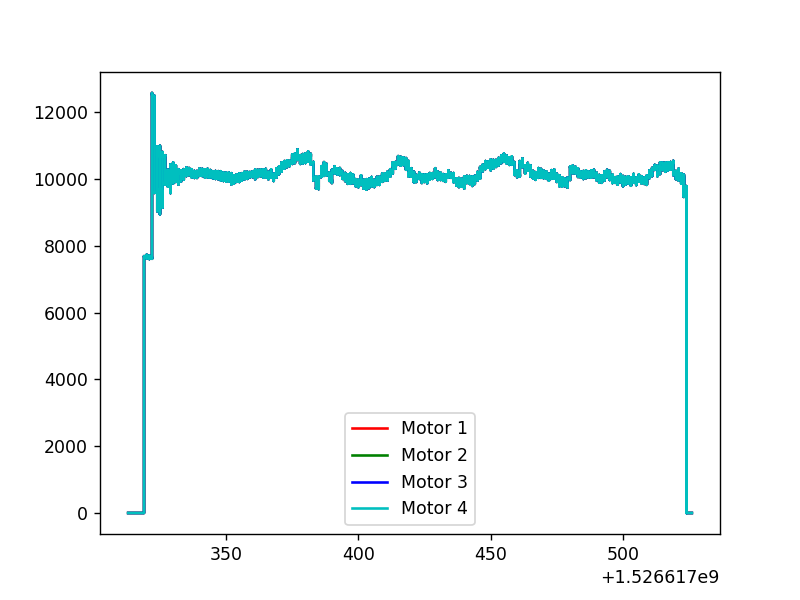

In [25]:
fig = plt.figure()
ax = plt.subplot(1,1,1)

ax.plot(motors_df['secs'], motors_df['rpm1'], label='Motor 1', color='r')
ax.plot(motors_df['secs'], motors_df['rpm1'], label='Motor 2', color='g')
ax.plot(motors_df['secs'], motors_df['rpm1'], label='Motor 3', color='b')
ax.plot(motors_df['secs'], motors_df['rpm1'], label='Motor 4', color='c')

ax.legend()
plt.show()

<IPython.core.display.Javascript object>


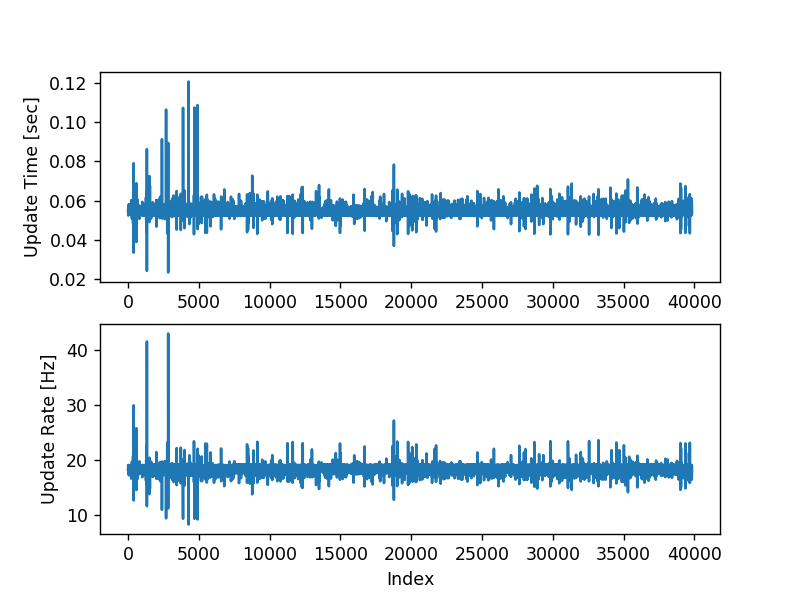

In [26]:
# Examine the reported update rates
update_time = motors_df['rosbagTimestamp'].diff()
update_time = update_time * (10 ** -8) #Shift to seconds

update_rate = 1./update_time # Hz is 1/sec

fig,ax = plt.subplots(2,1)

ax[0].plot(update_time)
ax[1].plot(update_rate)

ax[0].set_ylabel("Update Time [sec]")
ax[1].set_ylabel("Update Rate [Hz]")
ax[1].set_xlabel("Index")
plt.show()

<IPython.core.display.Javascript object>


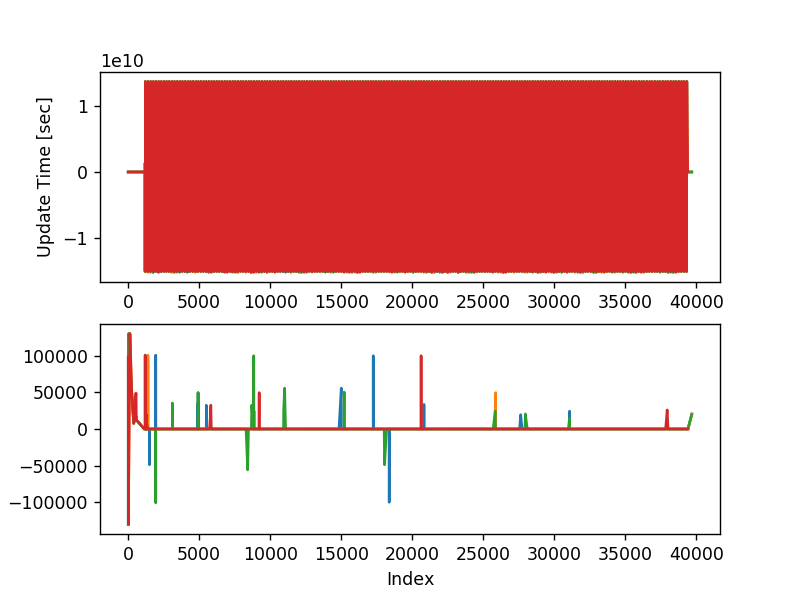

In [27]:
# Examine the reported update rates
update_time_m1 = motors_df['rosbagTimestamp_m1'].diff()
update_time_m2 = motors_df['rosbagTimestamp_m2'].diff()
update_time_m3 = motors_df['rosbagTimestamp_m3'].diff()
update_time_m4 = motors_df['rosbagTimestamp_m4'].diff()

update_time_m1.drop_duplicates(inplace=True)
update_time_m2.drop_duplicates(inplace=True)
update_time_m3.drop_duplicates(inplace=True)
update_time_m4.drop_duplicates(inplace=True)

update_time_m1 = update_time_m1 * (10 ** -8) #Shift to seconds
update_time_m2 = update_time_m2 * (10 ** -8) #Shift to seconds
update_time_m3 = update_time_m3 * (10 ** -8) #Shift to seconds
update_time_m4 = update_time_m4 * (10 ** -8) #Shift to seconds


update_rate_m1 = 1./update_time_m1 # Hz is 1/sec
update_rate_m2 = 1./update_time_m2 # Hz is 1/sec
update_rate_m3 = 1./update_time_m3 # Hz is 1/sec
update_rate_m4 = 1./update_time_m4 # Hz is 1/sec

fig,ax = plt.subplots(2,1)

ax[0].plot(update_time_m1)
ax[0].plot(update_time_m2)
ax[0].plot(update_time_m3)
ax[0].plot(update_time_m4)
ax[1].plot(update_rate_m1)
ax[1].plot(update_rate_m2)
ax[1].plot(update_rate_m3)
ax[1].plot(update_rate_m4)

ax[0].set_ylabel("Update Time [sec]")
ax[1].set_ylabel("Update Rate [Hz]")
ax[1].set_xlabel("Index")
plt.show()

### Pose Ref CSV

This csv file contains the flight maneuver reference way points. This is updating at approximately 20 Hz.


In [28]:
url = urlhead + "blackbird_slash_pose_ref.csv"
pose_ref_df = pd.read_csv(io.StringIO(requests.get(url).content.decode('utf-8')))
pose_ref_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38131 entries, 0 to 38130
Data columns (total 17 columns):
rosbagTimestamp    38131 non-null int64
header             0 non-null float64
seq                38131 non-null int64
stamp              0 non-null float64
secs               38131 non-null int64
nsecs              38131 non-null int64
frame_id           38131 non-null object
pose               0 non-null float64
position           0 non-null float64
x                  38131 non-null float64
y                  38131 non-null float64
z                  38131 non-null float64
orientation        0 non-null float64
x.1                38131 non-null float64
y.1                38131 non-null float64
z.1                38131 non-null float64
w                  38131 non-null float64
dtypes: float64(12), int64(4), object(1)
memory usage: 4.9+ MB


In [29]:
# Drop empty columns
pose_ref_df = pose_ref_df.drop(['header',\
                                'stamp',\
                                'pose',\
                                'position',\
                                'orientation'],\
                               axis=1)

#Rename variables and add units
pose_ref_df = pose_ref_df.rename(columns={"x" : "pxr_[m]",\
                                          "y" : "pyr_[m]",\
                                          "z" : "pzr_[m]",\
                                          "x.1" : "qxr",\
                                          "y.1" : "qyr",\
                                          "z.1" : "qzr",\
                                          "w" : "qwr"})

pose_ref_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38131 entries, 0 to 38130
Data columns (total 12 columns):
rosbagTimestamp    38131 non-null int64
seq                38131 non-null int64
secs               38131 non-null int64
nsecs              38131 non-null int64
frame_id           38131 non-null object
pxr_[m]            38131 non-null float64
pyr_[m]            38131 non-null float64
pzr_[m]            38131 non-null float64
qxr                38131 non-null float64
qyr                38131 non-null float64
qzr                38131 non-null float64
qwr                38131 non-null float64
dtypes: float64(7), int64(4), object(1)
memory usage: 3.5+ MB


<IPython.core.display.Javascript object>


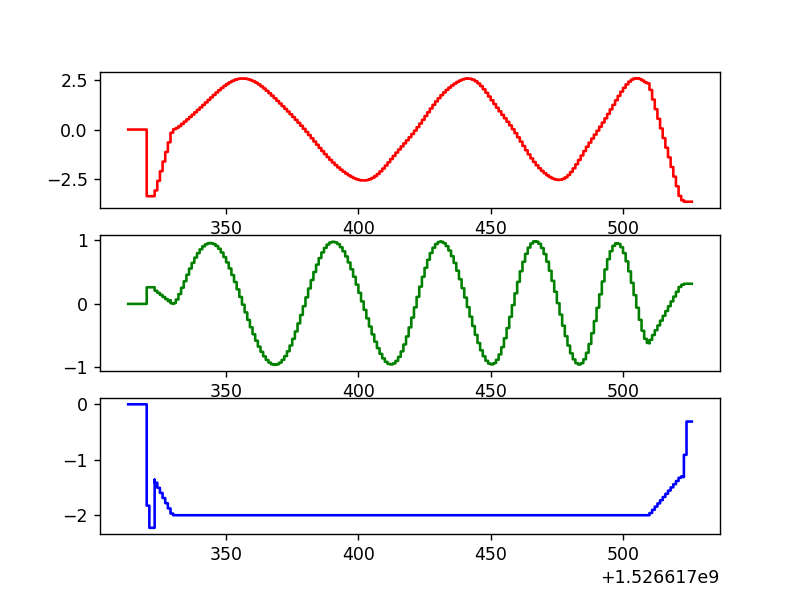

In [30]:
fig,ax = plt.subplots(3,1)

ax[0].plot(pose_ref_df['secs'], pose_ref_df['pxr_[m]'], label="X", color="r")
ax[1].plot(pose_ref_df['secs'], pose_ref_df['pyr_[m]'], label="Y", color="g")
ax[2].plot(pose_ref_df['secs'], pose_ref_df['pzr_[m]'], label="Z", color="b")

plt.show()

<IPython.core.display.Javascript object>


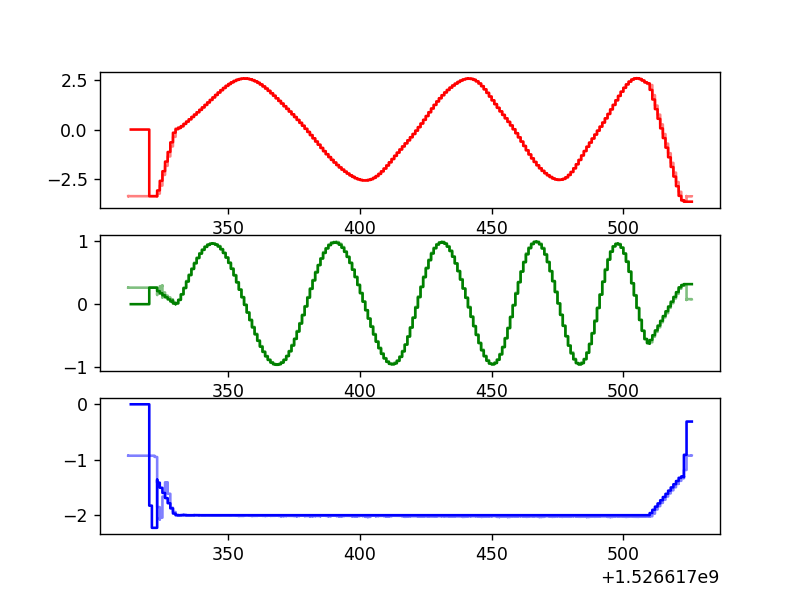

In [31]:
fig,ax = plt.subplots(3,1)

ax[0].plot(pose_ref_df['secs'], pose_ref_df['pxr_[m]'], label="X", color="r")
ax[1].plot(pose_ref_df['secs'], pose_ref_df['pyr_[m]'], label="Y", color="g")
ax[2].plot(pose_ref_df['secs'], pose_ref_df['pzr_[m]'], label="Z", color="b")
ax[0].plot(pos_and_orien['secs'], pos_and_orien['px_[m]'], color='r', alpha=0.5)
ax[1].plot(pos_and_orien['secs'], pos_and_orien['py_[m]'], color='g', alpha=0.5)
ax[2].plot(pos_and_orien['secs'], pos_and_orien['pz_[m]'], color='b', alpha=0.5)

plt.show()

<IPython.core.display.Javascript object>


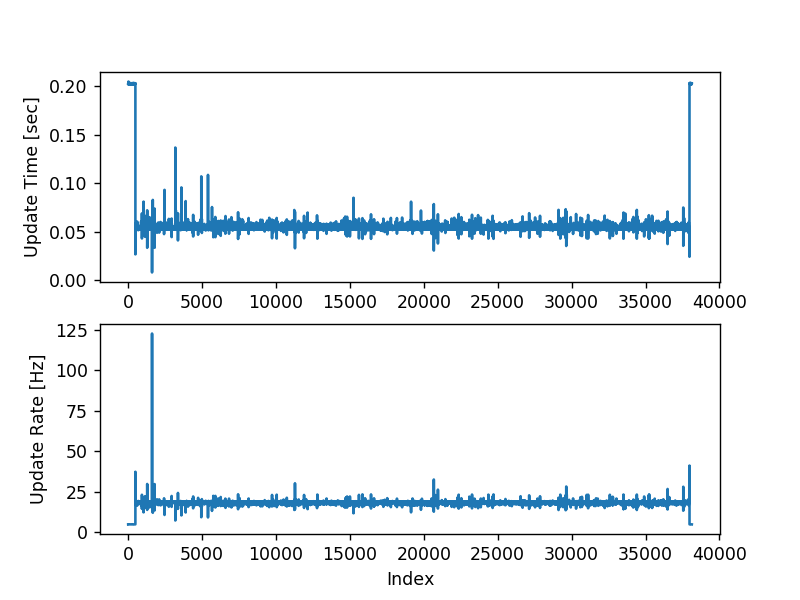

In [32]:
# Examine the reported update rates
update_time = pose_ref_df['rosbagTimestamp'].diff()
update_time = update_time * (10 ** -8) #Shift to seconds

update_rate = 1./update_time # Hz is 1/sec

fig,ax = plt.subplots(2,1)

ax[0].plot(update_time)
ax[1].plot(update_rate)

ax[0].set_ylabel("Update Time [sec]")
ax[1].set_ylabel("Update Rate [Hz]")
ax[1].set_xlabel("Index")
plt.show()

## Data Merging

Since all the interesting states are in different CSV files, it is necessary to merge all individual dataframe into a singular test data frame. Merging will be based on the Rosbag Timestamp which serves as a standard time across all csv files.

In [33]:
# Set all non motor dataframe index to the timestamp
pos_and_orien.set_index('rosbagTimestamp', inplace=True)
imu_df.set_index('rosbagTimestamp', inplace=True)
pwm_df.set_index('rosbagTimestamp', inplace=True)
pose_ref_df.set_index('rosbagTimestamp', inplace=True)

In [34]:
#Drop mention of seconds and nano-seconds as well as frames and sequences
drop_columns = ['secs', 'nsecs', 'frame_id', 'seq']

pos_and_orien = pos_and_orien.drop(drop_columns, axis=1)
imu_df        = imu_df.drop(drop_columns, axis=1)
pwm_df        = pwm_df.drop(drop_columns, axis=1)
pose_ref_df   = pose_ref_df.drop(drop_columns, axis=1)

In [35]:
#Making the motors into their own dataframes
m1_df = motors_df[['rosbagTimestamp_m1', 'rpm1']]
m2_df = motors_df[['rosbagTimestamp_m2', 'rpm2']]
m3_df = motors_df[['rosbagTimestamp_m3', 'rpm3']]
m4_df = motors_df[['rosbagTimestamp_m4', 'rpm4']]

#renaming columns so that for concatenation
m1_df = m1_df.rename(columns={'rosbagTimestamp_m1' : 'rosbagTimestamp'})
m2_df = m2_df.rename(columns={'rosbagTimestamp_m2' : 'rosbagTimestamp'})
m3_df = m3_df.rename(columns={'rosbagTimestamp_m3' : 'rosbagTimestamp'})
m4_df = m4_df.rename(columns={'rosbagTimestamp_m4' : 'rosbagTimestamp'})

#Setting the index o fthe motors
m1_df.set_index('rosbagTimestamp', inplace=True)
m2_df.set_index('rosbagTimestamp', inplace=True)
m3_df.set_index('rosbagTimestamp', inplace=True)
m4_df.set_index('rosbagTimestamp', inplace=True)

In [36]:
#Concatenating of the dataframes
test_df = pd.concat([pos_and_orien, pose_ref_df, imu_df, pwm_df.drop(['pwm'], axis=1), m1_df, m2_df, m3_df, m4_df],sort=True)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 335840 entries, 1.526617312016142e+18 to nan
Data columns (total 34 columns):
PWM1                              39823 non-null float64
PWM2                              39823 non-null float64
PWM3                              39823 non-null float64
PWM4                              39823 non-null float64
angular_velocity_covariance       21298 non-null object
ax_[m/s2]                         21298 non-null float64
ay_[m/s2]                         21298 non-null float64
az_[m/s2]                         21298 non-null float64
linear_acceleration_covariance    21298 non-null object
omegax_[dps]                      21298 non-null float64
omegay_[dps]                      21298 non-null float64
omegaz_[dps]                      21298 non-null float64
orientation_covariance            21298 non-null object
pitch_[rad]                       77286 non-null float64
px_[m]                            77287 non-null float64
pxr_[m]           